## 1. Simple Graph

In [1]:
from typing import TypedDict

class PortfolioState(TypedDict):
    amount_usd: float
    total_usd: float
    total_inr: float

In [2]:
def calc_total(state: PortfolioState) -> PortfolioState:
    state['total_usd'] = state['amount_usd'] * 1.08
    return state

def convert_to_inr(state: PortfolioState) -> PortfolioState:
    state['total_inr'] = state['total_usd'] * 85
    return state

In [3]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(PortfolioState)

builder.add_node("calc_total_node", calc_total)
builder.add_node("convert_to_inr_node", convert_to_inr)

builder.add_edge(START, "calc_total_node")
builder.add_edge("calc_total_node", "convert_to_inr_node")
builder.add_edge("convert_to_inr_node", END)

graph = builder.compile()

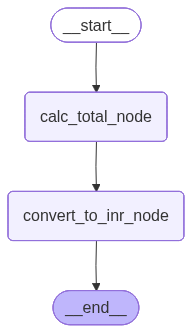

In [4]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
graph.invoke({"amount_usd": 100000})

{'amount_usd': 100000, 'total_usd': 108000.0, 'total_inr': 9180000.0}

## 2. Graph with Condition

In [6]:
from typing import Literal

class PortfolioState(TypedDict):
    amount_usd: float
    total_usd: float
    target_currency: Literal["INR", "EUR"]
    total: float

In [7]:
def convert_to_inr(state: PortfolioState) -> PortfolioState:
    state['total'] = state['total_usd'] * 85
    return state
    
def convert_to_eur(state: PortfolioState) -> PortfolioState:
    state['total'] = state['total_usd'] * 0.9
    return state

def choose_conversion(state: PortfolioState) -> str:
    return state["target_currency"]

In [8]:
builder = StateGraph(PortfolioState)

builder.add_node("calc_total_node", calc_total)
builder.add_node("convert_to_inr_node", convert_to_inr)
builder.add_node("convert_to_eur_node", convert_to_eur)

builder.add_edge(START, "calc_total_node")
builder.add_conditional_edges(
    "calc_total_node",
    choose_conversion,
    {
        "INR": "convert_to_inr_node",
        "EUR": "convert_to_eur_node",
    }
)
builder.add_edge(["convert_to_inr_node", "convert_to_eur_node"], END)

graph = builder.compile()

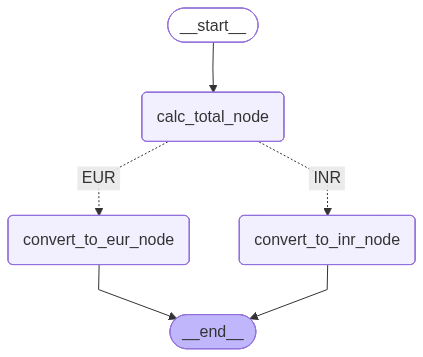

In [9]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
graph.invoke({"amount_usd": 1000, "target_currency": "EUR"})

{'amount_usd': 1000,
 'total_usd': 1080.0,
 'target_currency': 'EUR',
 'total': 972.0}

In [11]:
graph.invoke({"amount_usd": 1000, "target_currency": "INR"})

{'amount_usd': 1000,
 'total_usd': 1080.0,
 'target_currency': 'INR',
 'total': 91800.0}

## 3. Chatbot

In [14]:
import os
import getpass

os.environ["GOOGLE_API_KEY"] = getpass.getpass()

 ········


In [12]:
from langchain.chat_models import init_chat_model
from typing import Annotated
from langgraph.graph.message import add_messages

In [15]:
llm = init_chat_model("google_genai:gemini-2.0-flash")

In [16]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
# Messages have the type "list".
# The `add_messages` function in the annotation defines how this state key should be updated
# (in this case, it appends messages to the list, rather than overwriting them)

def chatbot(state: State) -> State:
    return {"messages": [llm.invoke(state["messages"])]}

In [17]:
builder = StateGraph(State)
builder.add_node("chatbot_node", chatbot)

builder.add_edge(START, "chatbot_node")
builder.add_edge("chatbot_node", END)

graph = builder.compile()

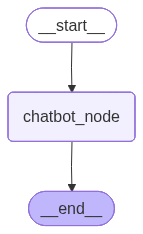

In [18]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
message = {"role": "user", "content": "What is my name?"}
response = graph.invoke({"messages": [message]})
response["messages"]

[HumanMessage(content='What is my name?', additional_kwargs={}, response_metadata={}, id='55ac9bdb-413a-46b6-8dc2-4e8ad05aa61f'),
 AIMessage(content='As an AI, I do not know your name. I have no memory of past conversations and no access to personal information. You have not provided me with your name.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--13b92e5a-203c-4947-8c9c-babeb5d59f8a-0', usage_metadata={'input_tokens': 5, 'output_tokens': 35, 'total_tokens': 40, 'input_token_details': {'cache_read': 0}})]

In [20]:
state = None
in_message = input("You: ")
while in_message != "exit":
    if in_message.lower() in {"quit","exit"}:
        break
    if state is None:
        state: State = {
            "messages": [{"role": "user", "content": in_message}]
        }
    else:
        state["messages"].append({"role": "user", "content": in_message})

    state = graph.invoke(state)
    print("Bot:", state["messages"][-1].content)
    in_message = input("You: ")

You:  what is a cat?


Bot: A cat is a small, typically furry, carnivorous mammal. Here's a more detailed breakdown:

**Biologically:**

*   **Kingdom:** Animalia (Animals)
*   **Phylum:** Chordata (Animals with a spinal cord)
*   **Class:** Mammalia (Mammals)
*   **Order:** Carnivora (Meat-eaters)
*   **Family:** Felidae (Cats)
*   **Genus:** *Felis* (in the case of domestic cats)
*   **Species:** *Felis catus* (Domestic cat)

**Characteristics:**

*   **Physical:**
    *   Typically small (compared to other carnivores).
    *   Agile and flexible body.
    *   Sharp claws that are usually retractable.
    *   Excellent night vision.
    *   Sensitive hearing and sense of smell.
    *   Whiskers for sensing their environment.
*   **Behavioral:**
    *   Known for being independent and adaptable.
    *   Natural hunters, even when well-fed.
    *   Communicate through vocalizations (meows, purrs, hisses), body language, and scent marking.
    *   Playful and curious.
    *   Groom themselves regularly.

**In

You:  what does it eat?


Bot: A cat's diet is primarily carnivorous, meaning they need to eat meat to thrive. Here's a breakdown:

**Primary Food Sources:**

*   **Meat:** Cats require a high protein diet. Meat provides essential amino acids, like taurine, which are vital for their health and cannot be synthesized adequately by their bodies. This includes muscle meat, organ meat (like liver and kidneys), and even bones.
*   **Cat Food (Commercial):** Most domestic cats are fed commercially prepared cat food. This comes in two main forms:
    *   **Dry Food (Kibble):** Convenient and often more affordable. Look for high-quality brands with meat as the primary ingredient.
    *   **Wet Food (Canned or Pouches):** Generally higher in moisture content, which is beneficial for cats. Can be more palatable for some cats.
*   **Prey:** Cats that live outdoors or have access to the outdoors will often hunt and eat small animals, such as:
    *   Mice and rats
    *   Birds
    *   Insects
    *   Small reptiles (lizard

You:  exit


## 4. Tool Call

In [21]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

In [22]:
@tool
def get_stock_price(symbol: str) -> float:
    '''Return the current price of a stock given the stock symbol
    :param symbol: stock symbol
    :return: current price of the stock
    '''
    return {
        "MSFT": 200.3,
        "AAPL": 100.4,
        "AMZN": 150.0,
        "RIL": 87.6
    }.get(symbol, 0.0)

tools = [get_stock_price]

In [23]:
llm_with_tools = llm.bind_tools(tools)

In [24]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [25]:
builder = StateGraph(State)

builder.add_node("chatbot_node", chatbot)
builder.add_node("tools", ToolNode(tools)) #has to be named "tools"
#builder.add_node("tools_node", ToolNode(tools))

builder.add_edge(START, "chatbot_node")
builder.add_conditional_edges("chatbot_node", tools_condition)
# builder.add_conditional_edges("chatbot_node",
#                               tools_condition,
#                               {
#                                   "tools": "tools_node",
#                                   END: END,
#                               })

graph = builder.compile()

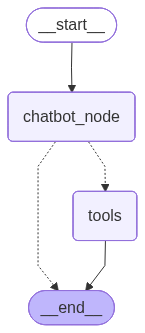

In [26]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
state = graph.invoke({"messages": [{"role": "user", "content": "What is the price of AAPL stock right now?"}]})
print(state["messages"][-1].content)

100.4


In [28]:
state #tool call made

{'messages': [HumanMessage(content='What is the price of AAPL stock right now?', additional_kwargs={}, response_metadata={}, id='c550d231-c7d9-40b1-a6dd-68ab0d1f6b4d'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_stock_price', 'arguments': '{"symbol": "AAPL"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--c2838a8f-764b-4892-a5b9-c74d30cb6ce9-0', tool_calls=[{'name': 'get_stock_price', 'args': {'symbol': 'AAPL'}, 'id': 'd0a7a797-4886-4467-a9a4-b9340597984f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 47, 'output_tokens': 8, 'total_tokens': 55, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='100.4', name='get_stock_price', id='da14fa4a-6730-4361-a5c6-078f8c82ee2e', tool_call_id='d0a7a797-4886-4467-a9a4-b9340597984f')]}

In [29]:
state = graph.invoke({"messages": [{"role": "user", "content": "Who invented theory of relativity? print person name only"}]})
print(state["messages"][-1].content)

Albert Einstein


In [30]:
state #no tool call made

{'messages': [HumanMessage(content='Who invented theory of relativity? print person name only', additional_kwargs={}, response_metadata={}, id='9525c129-74af-4dff-8a20-27cb0d432f4c'),
  AIMessage(content='Albert Einstein', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--c18cfa7e-2423-46a1-b61d-65396021b2c8-0', usage_metadata={'input_tokens': 46, 'output_tokens': 3, 'total_tokens': 49, 'input_token_details': {'cache_read': 0}})]}

In [31]:
state = graph.invoke({"messages":
                      [{"role": "user",
                        "content": "I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?"}]})
print(state["messages"][-1].content)

200.3


In [32]:
state # made 2 tool calls but didn't take response back to LLM

{'messages': [HumanMessage(content='I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?', additional_kwargs={}, response_metadata={}, id='26bbd671-b014-4e22-a357-de8fa58de44b'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_stock_price', 'arguments': '{"symbol": "MSFT"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--afc2b17e-d095-4b82-8932-35b2fb9182fa-0', tool_calls=[{'name': 'get_stock_price', 'args': {'symbol': 'AMZN'}, 'id': 'c184b855-dd30-43e3-b729-5b55b782d76d', 'type': 'tool_call'}, {'name': 'get_stock_price', 'args': {'symbol': 'MSFT'}, 'id': 'dcf79a12-dd89-48a0-9d5d-d20adbcb92da', 'type': 'tool_call'}], usage_metadata={'input_tokens': 64, 'output_tokens': 16, 'total_tokens': 80, 'input_token_details': {'cache_read': 0}})

## 5. Tool Call with Agent

In [27]:
builder = StateGraph(State)

builder.add_node(chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
builder.add_edge("tools", "chatbot")

graph = builder.compile()

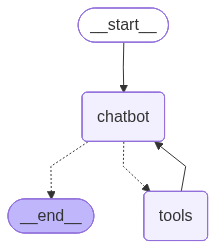

In [28]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [35]:
state = graph.invoke({"messages":
                      [{"role": "user",
                        "content": "I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?"}]})
print(state["messages"][-1].content)

The current price for AMZN is $150 and for MSFT is $200.3.
The total cost for 20 AMZN stocks is 20 * $150 = $3000.
The total cost for 15 MSFT stocks is 15 * $200.3 = $3004.5.
Therefore, the total cost for both is $3000 + $3004.5 = $6004.5.


In [36]:
state # LLM made Tool Call twice and gave responses back to LLM to make AI call for final result

{'messages': [HumanMessage(content='I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?', additional_kwargs={}, response_metadata={}, id='16a9d6a0-4718-4e5b-8c8b-b13c31ab8089'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_stock_price', 'arguments': '{"symbol": "MSFT"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--12339bb9-cfb3-45c8-b828-510a79d46fef-0', tool_calls=[{'name': 'get_stock_price', 'args': {'symbol': 'AMZN'}, 'id': '08011cb3-4dd4-43c3-b519-f97fb47b10bd', 'type': 'tool_call'}, {'name': 'get_stock_price', 'args': {'symbol': 'MSFT'}, 'id': '52a784f6-65b4-444d-bd66-1b16ed75b75a', 'type': 'tool_call'}], usage_metadata={'input_tokens': 64, 'output_tokens': 16, 'total_tokens': 80, 'input_token_details': {'cache_read': 0}})

## 6. Memory

In [29]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [30]:
builder = StateGraph(State)

builder.add_node(chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
builder.add_edge("tools", "chatbot")

graph = builder.compile(checkpointer=memory)

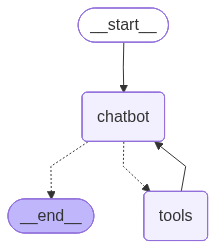

In [31]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [32]:
config1 = { 'configurable': { 'thread_id': '1'} }

msg = "I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]}, config=config1)
print(state["messages"][-1].content)

OK. The current price for AMZN is $150 and for MSFT is $200.3.
The total cost for 20 AMZN stocks is 20 * $150 = $3000.
The total cost for 15 MSFT stocks is 15 * $200.3 = $3004.5.
Therefore, the total cost for both is $3000 + $3004.5 = $6004.5.


In [21]:
config2 = { 'configurable': { 'thread_id': '2'} }

msg = "Tell me the current price of 5 AAPL stocks."

state = graph.invoke({"messages": [{"role": "user", "content": msg}]}, config=config2)
print(state["messages"][-1].content)

The current price of one AAPL stock is $100.4. Therefore, the current price of 5 AAPL stocks is $502.0.


In [33]:
msg = "Using the current price tell me the total price of 10 RIL stocks and add it to previous total cost"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]}, config=config1)
print(state["messages"][-1].content)

OK. The current price for RIL is $87.6. The total cost for 10 RIL stocks is 10 * $87.6 = $876.
Adding this to the previous total cost of $6004.5, the new total cost is $6004.5 + $876 = $6880.5.


In [23]:
msg = "Tell me the current price of 5 MSFT stocks and add it to previous total"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]}, config=config2)
print(state["messages"][-1].content)

The current price of one MSFT stock is $200.3. Therefore, the current price of 5 MSFT stocks is $1001.5. Adding that to the previous total of $502.0, the new total is $1503.5.


## 7. LangSmith Tracing (Restart Kernel)

In [1]:
import os
import getpass

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()
os.environ["LANGSMITH_PROJECT"] = "langgraph-crash-course"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"

 ········


In [4]:
os.environ["GOOGLE_API_KEY"] = getpass.getpass()

 ········


In [2]:
from langchain.chat_models import init_chat_model
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

In [7]:
class State(TypedDict):
    # Messages have the type "list".
    # The `add_messages` function in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [5]:
@tool
def get_stock_price(symbol: str) -> float:
    '''Return the current price of a stock given the stock symbol
    :param symbol: stock symbol
    :return: current price of the stock
    '''
    return {
        "MSFT": 200.3,
        "AAPL": 100.4,
        "AMZN": 150.0,
        "RIL": 87.6
    }.get(symbol, 0.0)

tools = [get_stock_price]

llm = init_chat_model("google_genai:gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

In [9]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}
    
builder = StateGraph(State)

builder.add_node(chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
builder.add_edge("tools", "chatbot")

graph = builder.compile()

In [10]:
from langsmith import traceable

@traceable
def call_graph(query: str):
    state = graph.invoke({"messages": [{"role": "user", "content": query}]})
    return state["messages"][-1].content

call_graph("I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?")

'The current price for AMZN is $150 and for MSFT is $200.3.\nThe total cost for 20 AMZN stocks is 20 * $150 = $3000.\nThe total cost for 15 MSFT stocks is 15 * $200.3 = $3004.5.\nTherefore, the total cost for both is $3000 + $3004.5 = $6004.5.'

## 8. Human In The Loop (Restart Kernel)

In [1]:
from langchain.chat_models import init_chat_model
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command

In [2]:
import os
import getpass

os.environ["GOOGLE_API_KEY"] = getpass.getpass()

 ········


In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [4]:
@tool
def get_stock_price(symbol: str) -> float:
    '''Return the current price of a stock given the stock symbol'''
    return {"MSFT": 200.3, "AAPL": 100.4, "AMZN": 150.0, "RIL": 87.6}.get(symbol, 0.0)
    
@tool
def buy_stocks(symbol: str, quantity: int, total_price: float) -> str:
    '''Buy stocks given the stock symbol and quantity'''
    return f"You bought {quantity} shares of {symbol} for a total price of {total_price}"
    # decision = interrupt(f"Approve buying {quantity} {symbol} stocks for ${total_price:.2f}?")

    # if decision == "yes":
    #     return f"You bought {quantity} shares of {symbol} for a total price of {total_price}"
    # else:
    #     return "Buying declined."

In [6]:
tools = [get_stock_price, buy_stocks]

In [9]:
llm = init_chat_model("google_genai:gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    msg = llm_with_tools.invoke(state["messages"])
    return {"messages": [msg]}

In [10]:
memory = MemorySaver()

builder = StateGraph(State)

builder.add_node("chatbot_node", chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot_node")
builder.add_conditional_edges("chatbot_node", tools_condition)
builder.add_edge("tools", "chatbot_node")

graph = builder.compile(checkpointer=memory)

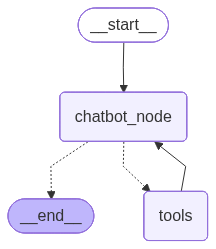

In [12]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
config = {"configurable": {"thread_id": "buy_thread"}}

In [17]:
# Step 1: user asks price
state = graph.invoke({"messages":[{"role":"user","content":"What is the current price of 10 MSFT stocks?"}]}, config=config)
print(state["messages"][-1].content)

The current price for one MSFT stock is $200.3. Therefore, the current price for 10 MSFT stocks is $2003.0.


## No Human Intervention

In [18]:
# Step 2: user asks to buy
state = graph.invoke({"messages":[{"role":"user","content":"Buy 10 MSFT stocks at current price."}]}, config=config)
print(state["messages"][-1].content)

OK. You bought 10 shares of MSFT for a total price of $2003.0.


## Human Intervention

In [1]:
from langchain.chat_models import init_chat_model
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command

In [2]:
import os
import getpass

os.environ["GOOGLE_API_KEY"] = getpass.getpass()

 ········


In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [4]:
@tool
def get_stock_price(symbol: str) -> float:
    '''Return the current price of a stock given the stock symbol'''
    return {"MSFT": 200.3, "AAPL": 100.4, "AMZN": 150.0, "RIL": 87.6}.get(symbol, 0.0)
    
@tool
def buy_stocks(symbol: str, quantity: int, total_price: float) -> str:
    '''Buy stocks given the stock symbol and quantity'''
    decision = interrupt(f"Approve buying {quantity} {symbol} stocks for ${total_price:.2f}?")

    if decision == "yes":
        return f"You bought {quantity} shares of {symbol} for a total price of {total_price}"
    else:
        return "Buying declined."

In [5]:
tools = [get_stock_price, buy_stocks]

In [6]:
llm = init_chat_model("google_genai:gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    msg = llm_with_tools.invoke(state["messages"])
    return {"messages": [msg]}

In [7]:
memory = MemorySaver()

builder = StateGraph(State)

builder.add_node("chatbot_node", chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot_node")
builder.add_conditional_edges("chatbot_node", tools_condition)
builder.add_edge("tools", "chatbot_node")

graph = builder.compile(checkpointer=memory)

In [8]:
config = {"configurable": {"thread_id": "buy_thread"}}

In [9]:
# Step 1: user asks price
state = graph.invoke({"messages":[{"role":"user","content":"What is the current price of 10 MSFT stocks?"}]}, config=config)
print(state["messages"][-1].content)

The current price of one MSFT stock is $200.3. Therefore, the current price of 10 MSFT stocks is $2003.


In [10]:
# Step 2: user asks to buy
state = graph.invoke({"messages":[{"role":"user","content":"Buy 10 MSFT stocks at current price."}]}, config=config)
print(state.get("__interrupt__"))

[Interrupt(value='Approve buying 10 MSFT stocks for $2003.00?', id='738ed2f8800b82c95d024098a2c164d3')]


In [12]:
decision = input("Approve (yes/no): ")
state = graph.invoke(Command(resume=decision), config=config)
print(state["messages"][-1].content)

Approve (yes/no):  yes


OK. You bought 10 shares of MSFT for a total price of $2003.0.


In [11]:
decision = input("Approve (yes/no): ")
state = graph.invoke(Command(resume=decision), config=config)
print(state["messages"][-1].content)

Approve (yes/no):  no


I am sorry, I was not able to buy the stocks. The transaction was declined.
